In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data  as data
import torch.nn.functional as F
import torchvision
import torchvision.models as models
from torchvision import transforms
from torchsummary import summary

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


In [2]:
# Проверка работоспособности, что PIL может открыть файл с изображением
def check_image(path):
    try:
        img = Image.open(path)
        return True
    except:
        return False


In [33]:
# Параметры
batch_size = 128
latent_dims = 2
n_epochs = 10
learning_rate = 1e-3


In [4]:
# Трансформация  датасета в размерность Pytorch 
img_transform = transforms.Compose([transforms.ToTensor()])

# Создание и загрузка обучающей выборки
train_data = torchvision.datasets.FashionMNIST(root='.data/FashionMNIST', download=True, 
                                               train=True, transform=img_transform)
train_dataloader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Создание и загрузка тестовой выборки
val_data = torchvision.datasets.FashionMNIST(root='.data/FashionMNIST', download=True, 
                                             train=False, transform=img_transform)
val_dataloader = data.DataLoader(val_data, batch_size=batch_size, shuffle=False)



Extracting .data/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to .data/FashionMNIST/FashionMNIST/raw




Extracting .data/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to .data/FashionMNIST/FashionMNIST/raw




Extracting .data/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to .data/FashionMNIST/FashionMNIST/raw




Extracting .data/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to .data/FashionMNIST/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
class_names = ['Футболка', 'Брюки/Шорты', 'Свитер', 'Платье', 'Куртка/Плащ', 'Сандали', 'Рубашка', 'Кросовки', 'Сумка', 'Ботинки']


In [6]:
# Изображения в формат PIL
data = iter(train_dataloader)
X_data, y_data = data.next()


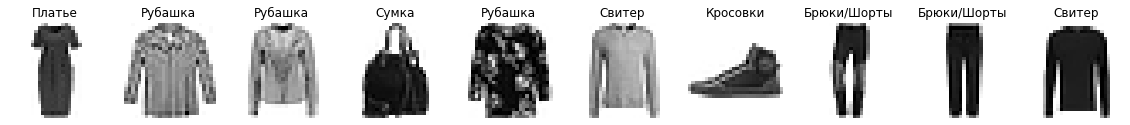

In [7]:
# Выводим 10 оригинальных изображений
plt.figure(figsize=(20, 4))
for i in range(10):
    plt.subplot(1,10, i+1)
    plt.axis('off')
    plt.imshow(X_data[i,:,:,:].numpy().reshape(28,28), cmap="gray_r")
    plt.title(class_names[y_data[i].item()])
plt.show()


In [8]:
# Автоэнкодер с линейными слоями
class Autoencoder(nn.Module):

    def __init__(self):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 32))
        
        self.decoder = nn.Sequential(
            nn.Linear(32, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28*28)
            )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded
        

In [9]:
autoencoder = Autoencoder()


In [10]:
# Оптимайзер и ошибка
optimizer = optim.Adam(params=autoencoder.parameters(), lr=learning_rate)

criterion  = torch.nn.MSELoss()


In [21]:
# Kопируем модель в графический процессор, если он доступен
if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

autoencoder.to(device)


Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
  )
)

In [26]:
# Выводим структуру сети
summary(autoencoder, (1, 28*28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 512]         401,920
              ReLU-2               [-1, 1, 512]               0
            Linear-3               [-1, 1, 256]         131,328
              ReLU-4               [-1, 1, 256]               0
            Linear-5                [-1, 1, 32]           8,224
            Linear-6               [-1, 1, 256]           8,448
              ReLU-7               [-1, 1, 256]               0
            Linear-8               [-1, 1, 512]         131,584
              ReLU-9               [-1, 1, 512]               0
           Linear-10               [-1, 1, 784]         402,192
Total params: 1,083,696
Trainable params: 1,083,696
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 4.13
Estimat

In [39]:
# Функция обучения сети
def train(model, train_loader, optimizer, log_interval):
    model.train()
    sum_train_loss = 0
    for batch_idx,(image, _) in enumerate(train_loader):
        image = image.view(-1, 28*28).to(device)
        target = image.view(-1, 28*28).to(device)
        optimizer.zero_grad()
        encoded, decoded = model(image)
        loss = criterion(decoded, target)
        loss.backward()
        optimizer.step()
        
        sum_train_loss += loss.detach().data
        
        # Вывод на экран результатов обучения
        #if (batch_idx+1) % 100 == 0:
        if batch_idx % log_interval == 24:
            print(f'Эпоха обучения № {epoch} из {n_epochs}  ||  Выполнено: {batch_idx * len(image)} из {len(train_loader.dataset)}  ->  {100.*batch_idx/len(train_dataloader):.2f} % \
                 \nОшибка на обучающей выборке: {100*loss.item():.4f} %')


In [28]:
# Функция тестирования
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    real_image=[]
    gen_image=[]
    with torch.no_grad():
        for image, _ in test_loader:
            image = image.view(-1, 28 * 28).to(device)
            target = image.view(-1, 28 * 28).to(device)
            encoded, decoded = model(image)
            
            test_loss += criterion(decoded, image).item()
            real_image.append(image.to("cpu"))
            gen_image.append(decoded.to("cpu"))
            
    test_loss /= len(val_dataloader.dataset)
    return test_loss, real_image, gen_image


Эпоха обучения № 1 из 10  ||  Выполнено: 3072 из 60000  ->  5.12 %                  
Ошибка на обучающей выборке: 1.0313 %
Эпоха обучения № 1 из 10  ||  Выполнено: 28672 из 60000  ->  47.76 %                  
Ошибка на обучающей выборке: 0.8808 %
Эпоха обучения № 1 из 10  ||  Выполнено: 54272 из 60000  ->  90.41 %                  
Ошибка на обучающей выборке: 0.8802 %
Ошибка на тестовой выборке 0.0072 %


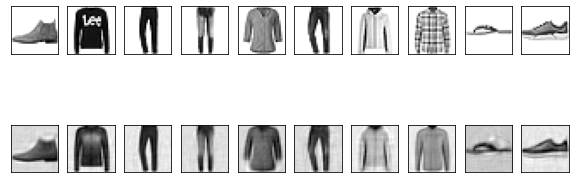

Эпоха обучения № 2 из 10  ||  Выполнено: 3072 из 60000  ->  5.12 %                  
Ошибка на обучающей выборке: 0.8781 %
Эпоха обучения № 2 из 10  ||  Выполнено: 28672 из 60000  ->  47.76 %                  
Ошибка на обучающей выборке: 0.9036 %
Эпоха обучения № 2 из 10  ||  Выполнено: 54272 из 60000  ->  90.41 %                  
Ошибка на обучающей выборке: 0.8987 %
Ошибка на тестовой выборке 0.0072 %


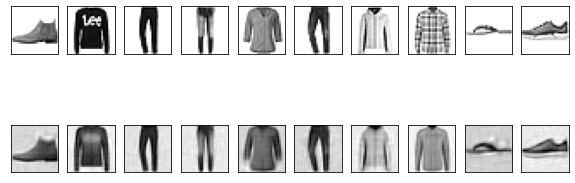

Эпоха обучения № 3 из 10  ||  Выполнено: 3072 из 60000  ->  5.12 %                  
Ошибка на обучающей выборке: 0.8525 %
Эпоха обучения № 3 из 10  ||  Выполнено: 28672 из 60000  ->  47.76 %                  
Ошибка на обучающей выборке: 0.8398 %
Эпоха обучения № 3 из 10  ||  Выполнено: 54272 из 60000  ->  90.41 %                  
Ошибка на обучающей выборке: 0.8160 %
Ошибка на тестовой выборке 0.0072 %


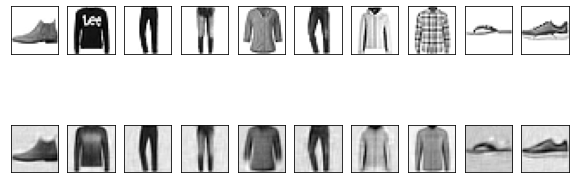

Эпоха обучения № 4 из 10  ||  Выполнено: 3072 из 60000  ->  5.12 %                  
Ошибка на обучающей выборке: 0.7800 %
Эпоха обучения № 4 из 10  ||  Выполнено: 28672 из 60000  ->  47.76 %                  
Ошибка на обучающей выборке: 0.9227 %
Эпоха обучения № 4 из 10  ||  Выполнено: 54272 из 60000  ->  90.41 %                  
Ошибка на обучающей выборке: 0.9019 %
Ошибка на тестовой выборке 0.0072 %


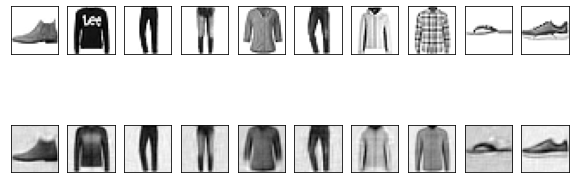

Эпоха обучения № 5 из 10  ||  Выполнено: 3072 из 60000  ->  5.12 %                  
Ошибка на обучающей выборке: 0.8396 %
Эпоха обучения № 5 из 10  ||  Выполнено: 28672 из 60000  ->  47.76 %                  
Ошибка на обучающей выборке: 0.8880 %
Эпоха обучения № 5 из 10  ||  Выполнено: 54272 из 60000  ->  90.41 %                  
Ошибка на обучающей выборке: 0.8844 %
Ошибка на тестовой выборке 0.0071 %


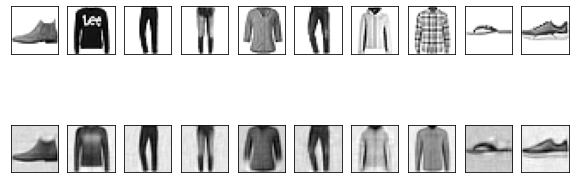

Эпоха обучения № 6 из 10  ||  Выполнено: 3072 из 60000  ->  5.12 %                  
Ошибка на обучающей выборке: 0.7506 %
Эпоха обучения № 6 из 10  ||  Выполнено: 28672 из 60000  ->  47.76 %                  
Ошибка на обучающей выборке: 0.9605 %
Эпоха обучения № 6 из 10  ||  Выполнено: 54272 из 60000  ->  90.41 %                  
Ошибка на обучающей выборке: 0.8459 %
Ошибка на тестовой выборке 0.0071 %


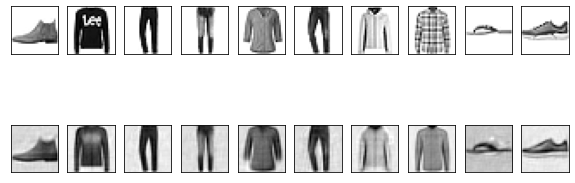

Эпоха обучения № 7 из 10  ||  Выполнено: 3072 из 60000  ->  5.12 %                  
Ошибка на обучающей выборке: 0.8742 %
Эпоха обучения № 7 из 10  ||  Выполнено: 28672 из 60000  ->  47.76 %                  
Ошибка на обучающей выборке: 0.9303 %
Эпоха обучения № 7 из 10  ||  Выполнено: 54272 из 60000  ->  90.41 %                  
Ошибка на обучающей выборке: 0.8860 %
Ошибка на тестовой выборке 0.0071 %


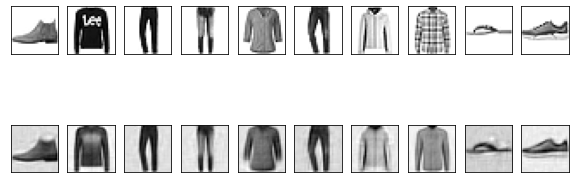

Эпоха обучения № 8 из 10  ||  Выполнено: 3072 из 60000  ->  5.12 %                  
Ошибка на обучающей выборке: 0.8188 %
Эпоха обучения № 8 из 10  ||  Выполнено: 28672 из 60000  ->  47.76 %                  
Ошибка на обучающей выборке: 0.8609 %
Эпоха обучения № 8 из 10  ||  Выполнено: 54272 из 60000  ->  90.41 %                  
Ошибка на обучающей выборке: 0.8402 %
Ошибка на тестовой выборке 0.0070 %


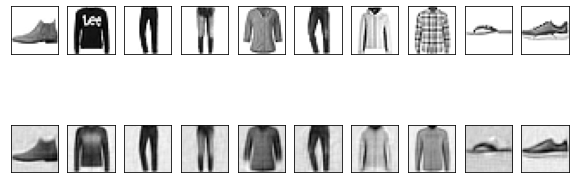

Эпоха обучения № 9 из 10  ||  Выполнено: 3072 из 60000  ->  5.12 %                  
Ошибка на обучающей выборке: 0.9807 %
Эпоха обучения № 9 из 10  ||  Выполнено: 28672 из 60000  ->  47.76 %                  
Ошибка на обучающей выборке: 0.8070 %
Эпоха обучения № 9 из 10  ||  Выполнено: 54272 из 60000  ->  90.41 %                  
Ошибка на обучающей выборке: 0.8493 %
Ошибка на тестовой выборке 0.0071 %


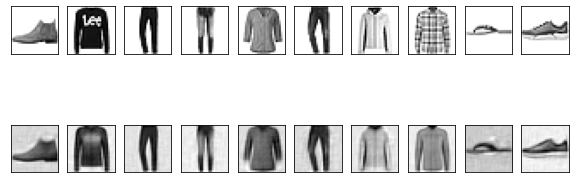

Эпоха обучения № 10 из 10  ||  Выполнено: 3072 из 60000  ->  5.12 %                  
Ошибка на обучающей выборке: 0.8574 %
Эпоха обучения № 10 из 10  ||  Выполнено: 28672 из 60000  ->  47.76 %                  
Ошибка на обучающей выборке: 0.8879 %
Эпоха обучения № 10 из 10  ||  Выполнено: 54272 из 60000  ->  90.41 %                  
Ошибка на обучающей выборке: 0.7450 %
Ошибка на тестовой выборке 0.0070 %


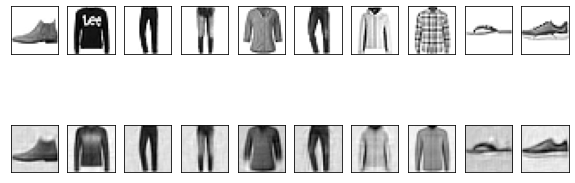

In [40]:
# Обучение и вывод на экран результатов по эпохам
for epoch in range(1, n_epochs + 1):
    train(autoencoder, train_dataloader, optimizer, log_interval=200)
    test_loss, real_image, gen_image = evaluate(autoencoder, val_dataloader)
    
    print(f'Ошибка на тестовой выборке {100*test_loss:.4f} %')

    f, a = plt.subplots(2, 10, figsize =(10, 4))
    
    for i in range(10):
        img = np.reshape(real_image[0][i],(28, 28))
        a[0][i].imshow(img, cmap ="gray_r")
        a[0][i].set_xticks(())
        a[0][i].set_yticks(())
        
    for i in range(10):
        img = np.reshape(gen_image[0][i],(28, 28))
        a[1][i].imshow(img, cmap ="gray_r")
        a[1][i].set_xticks(())
        a[1][i].set_yticks(())
    plt.show()
